In [3]:
import datetime                  # test + Uncertainty
import pandas as pd              # test + Uncertainty
import numpy as np               # test + Uncertainty
import pickle5 as pickle                    # Uncertainty
from tqdm import tqdm

#import test_model as tm          # test
import test_uncertainty_Softmax_v2 as tuc   # Uncertainty
from humanfriendly import format_timespan

from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

from sklearn.metrics import roc_auc_score
import performance

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from scipy.special import entr
from collections import Counter


PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


In [4]:
import torch
from torch.utils.data import DataLoader
import pytorch_pretrained_models as ppm

import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import argparse
from configparser import ConfigParser
import custom_dataset_TTA as cds
import data_ops as do

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, models, transforms
from scipy.special import softmax
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [5]:
from datetime import datetime
print(datetime.now())

2021-06-27 11:12:54.369914


In [96]:
class ResizeLargerSide(object):
    def __init__(self, output_size):
        super().__init__()
        self.output_size = output_size
    def __call__(self, img):
        w, h = img.size
        if h < w:
            new_w = self.output_size
            new_h = int(h*(self.output_size/w))
        elif w < h:
            new_h = self.output_size
            new_w = int(w*(self.output_size/h))
        else:  # w == h
            new_w = self.output_size
            new_h = self.output_size
        resized_img = img.resize((new_w, new_h))
        return resized_img

class RandomPad(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    def __call__(self, image):
        w, h = image.size
        new_h, new_w = self.output_size
        color = (255, 255, 255)
        pad_top, pad_bottom, pad_l, pad_r = 0, 0, 0, 0
        if h < new_h:  # need to pad height
            pad_top = np.random.randint(0, new_h - h)
        if w < new_w:  # need to pad width
            pad_l = np.random.randint(0, new_w - w)
        padded_img = Image.new(image.mode, (new_w, new_h), color)
        padded_img.paste(image, (pad_l, pad_top))
        return padded_img
    
# MEAN = [0.6802, 0.6802, 0.6802]
# STD = [0.2875, 0.2875, 0.2875]
MEAN = [0, 0, 0]
STD = [1, 1, 1]
#MEAN = [0.485, 0.456, 0.406]
#STD = [0.229, 0.224, 0.225]
SIZE = 224
RESIZE_RATIO = 0.9
input_size=224

IMAGE_SIZE=224
scale = 1.1

In [91]:
def _random_colour_space(x):
    output = x.convert("HSV") # HSV, YUV, and LAB
    return output

class GaussianNoise():
    """Adds gaussian noise to a tensor.

        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     Noise(0.1, 0.05)),
        >>> ])

    """
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor.add_(noise)

    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean}, stddev={self.stddev})"
        return repr

In [97]:
data_transforms_augmentation = {
                'train': transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    #transforms.RandomRotation(80, expand=True, center=None, fill=255),
                    ResizeLargerSide(int(RESIZE_RATIO*SIZE)),
                    #RandomPad(SIZE),
                    transforms.CenterCrop(SIZE),
                    #transforms.ColorJitter(brightness=0.1, contrast=0.1),
                    transforms.ToTensor(),
                    transforms.Normalize(MEAN, STD)
                ]), 
    
                'val2': transforms.Compose([
                      transforms.Resize(input_size),
#                     transforms.Scale(SIZE),
                      #transforms.TenCrop(input_size),
#                       transforms.RandomRotation(180, expand=True, center=None, fill=255),
                      ResizeLargerSide(int(RESIZE_RATIO*SIZE)),
                      transforms.CenterCrop(SIZE),
                      transforms.ColorJitter(brightness=0.5, contrast=0.5),
#                       transforms.Lambda(lambda normal: torch.stack([transforms.Normalize(MEAN, STD)(normalize) for normalize in normal]))
                      transforms.ToTensor(),
                      transforms.Normalize(MEAN, STD)
                 ]),
    
                'val': transforms.Compose([                    
                    ResizeLargerSide(int(RESIZE_RATIO*SIZE)),
                    transforms.Pad(SIZE//2, 255),
                    transforms.CenterCrop(SIZE),
                    #transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.ColorJitter(brightness=0.5, contrast=0.5),
                    transforms.Normalize(MEAN, STD)
                ]),
                'val4': transforms.Compose([
                    # order is also impostant, when I added this to the end, it failed to work
                    #transforms.RandomResizedCrop(200, scale=(0.08, 1.0), ratio=(0.75, 1.33)), # bad=12.5
                    transforms.ColorJitter(brightness=0.6, contrast=0.6), # bad=10%
                    #transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=0), # bad=95% to 83%
                    #transforms.RandomRotation(18, expand=True, center=None, fill=255),#no impact
                    #transforms.RandomRotation(18), # bad=53% if applied before standard transformations
                    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
                    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.1, 0.8), value=1, inplace=False),  # 10%
                    #transforms.functional.autocontrast(),
#                     transforms.Lambda(lambda x: _random_colour_space(x)),
                    #RGB, HSV, YUV, and LAB > this transform is applied to Image object so, it must be used
                    # before ToTensor()
                    #transforms.RandomApply([transforms.Lambda(lambda x: _random_colour_space(x))]), # no impact
                    #transforms.RandomHorizontalFlip(), # doesn't make any effect
                    ResizeLargerSide(int(RESIZE_RATIO*SIZE)),
                    transforms.Pad(SIZE//2, 255),
#                     transforms.RandomCrop(0.5, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),
                    transforms.CenterCrop(SIZE),
                    transforms.ToTensor(),
                    transforms.Normalize(MEAN, STD),   
                    #transforms.RandomRotation(18), # if used after standard transformations, just slightly drops the accuracy > 93.75
                    #transforms.GaussianBlur(11, sigma=(0.1, 2.0)) # no impact
                    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False), # no impact
                    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.1, 0.8), value=1, inplace=False),  # no impact
                    #transforms.RandomPerspective(distortion_scale=0.2, p=0.5, fill=0), # bad=95% to 93.75%
                    #transforms.RandomGrayscale(p=0.01), # ok=no impact=95.3125%
                    #GaussianNoise(mean=0.1,sttdev=0.05)
                    #GaussianNoise(0.1,0.05) #bad = 4.7%
#                     A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
                ]),
                'albumentations': A.Compose(
                        [
                            A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
                            A.PadIfNeeded(
                                min_height=int(IMAGE_SIZE * scale),
                                min_width=int(IMAGE_SIZE * scale),
                                border_mode=cv2.BORDER_CONSTANT,
                            ),
#                             A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
#                             A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
#                             A.OneOf(
#                                 [
#                                     A.ShiftScaleRotate(
#                                         rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT
#                                     ),
#                                     A.IAAAffine(shear=15, p=0.5, mode="constant"),
#                                 ],
#                                 p=1.0,
#                             ),
#                             A.HorizontalFlip(p=0.5),
#                             A.Blur(p=0.1),
#                             A.CLAHE(p=0.1),
#                             A.Posterize(p=0.1),
#                             A.ToGray(p=0.1),
#                             A.ChannelShuffle(p=0.05),
                            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
                            #A.Normalize(mean=MEAN, std=STD, max_pixel_value=255,),
                            ToTensorV2(),
                        ]),
    
                'val3': transforms.Compose([
#                       transforms.Resize(input_size),
#                     transforms.Scale(SIZE),
                      ResizeLargerSide(int(RESIZE_RATIO*SIZE)),
                      RandomPad(SIZE),                           # we have to add this
#                       transforms.Pad(SIZE//2, 255),
                      transforms.RandomGrayscale(p=0.01),
                      #transforms.RandomHorizontalFlip(p=0.5),
                      transforms.RandomAffine(degrees=2, translate=(.2, .2), scale=(0.5, 1), 
                                              fillcolor=(114, 114, 114),shear=(-0.3, 0.3, -0.3, 0.3)),
#                       transforms.RandomAffine(degrees=1, translate=(.2, .2), scale=(1 / 1.5, 1.5),
#                                           shear=(-1, 1, -1, 1)),
                      transforms.ToTensor(),
                    # TenCrop didn't provide a variety of images. with bare eyes, they were identical,
                    # there were 5 of them identical to each other and another 5 flipped horizontally
#                       transforms.TenCrop(input_size),
#                       transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
#                       transforms.Lambda(lambda normal: torch.stack([transforms.Normalize(MEAN, STD)(normalize) for normalize in normal]))                      
                 ]),
            }

In [8]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def idx2class(idx):
    return index_to_class[index_to_class['index']==idx]['class'][idx]

n_TTA=32
def extend_labels(label):
    return [label for x in range(n_TTA)]

In [125]:
import torchvision.io as io
# img_path = '../data/test/singles/MA160865191500037.005-K_11_1_.png'
img_path = '../data/test/singles/MA1867826.002-K_1_1_.png'
image_m = pil_loader(img_path)  # image_m = PIL.Image.Image
# image_io = io.imread(img_path)

In [126]:
type(image_m)
image_m.size   # (69, 166)   (119, 382) = (width, height)

(119, 382)

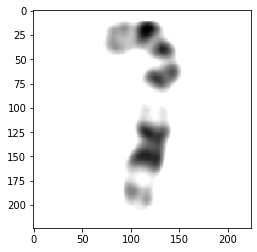

In [123]:
transform = data_transforms_augmentation['val4']
image_t = transform(image_m)   # image_t = torch.Tensor
#image2=transforms.functional.autocontrast(image2)
image_t = image_t.permute(1, 2, 0)
#image2 = image2.to('cpu')
#image2 = image2.detach().numpy()
# input_s.shape
plt.imshow(image_t, interpolation='nearest')
plt.show()

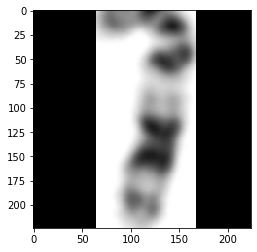

In [86]:
# ****** IF we use "albumentations" for transformations: ***********
transform = data_transforms_augmentation['albumentations']
image_arr = np.asarray(image_m)   # image_arr = numpy.ndarray
image_t = transform(image=image_arr)  # image_t = torch.Tensor
# image_t = transform(image=image_m)   # fails, can't accept PIL type for transformation
image_t = image_t['image'].permute(1, 2, 0)
plt.imshow(image_t, interpolation='nearest')
plt.show()

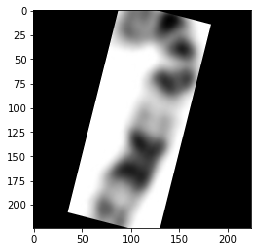

In [13]:
# ****** IF we use "albumentations" for transformations: ***********
transform = data_transforms_augmentation['albumentations']
image_arr = np.asarray(image_m)   # image_arr = numpy.ndarray
image_t = transform(image=image_arr)  # image_t = torch.Tensor
# image_t = transform(image=image_m)   # fails, can't accept PIL type for transformation
image_t = image_t['image'].permute(1, 2, 0)
plt.imshow(image_t, interpolation='nearest')
plt.show()

In [31]:
start_date=datetime.now()
config_path = '../config/config_densenet121_TTA.ini'
config = ConfigParser()
config.read(config_path)
l_pictures = []; l_outputs = []; l_labels = []

root_dir = config.get('model', 'root_dir')
data_dir = data_dir = config.get('data', 'data_dir')
model_list = {config.get('model', 'name')} 
num_classes = config.getint('model', 'num_classes')
batch_size = config.getint('model', 'batch_size')
shuffle = config.getboolean('data', 'shuffle')
t_data_set = config.get('test', 't_data_set')          # 'test' or 'val_test'
single_channel = config.getboolean('model', 'single_channel')
model_meta_csv = config.get('test', 'model_meta_csv') 
test_data_csv = f'{root_dir}data/test_data.csv'
data_transform = config.get('data', 'transform')

torch.manual_seed(config.getint('data', 'seed'))
np.random.seed(config.getint('data', 'seed'))

dops1 = do.dops(config)

pre_model_test = ppm.pt_model(config)
model_test, input_size = pre_model_test.initialize()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dops1.pick_data_transforms(data_transform, pre_model_test.input_size)
#model_test.load_state_dict(torch.load('../models/dir_densenet121/densenet121_11epochs_0.9566.weights', map_location=device))
model_path = '../models/dir_densenet121/albumentations1/densenet121_31epochs_0.9538.weights'
model_test.load_state_dict(torch.load(model_path, map_location=device))
model_test.eval()

if device == 'cpu':
    model_test.cpu()

test_dataset = cds.MyImageDataset(config, dops1, t_data_set = t_data_set)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

option=2 # [0, 1, 2] = [single_input, multiple_input, multiply_single_input]
aug_tst = 0; #n_TTA = 1
transform_type = 'albumentations'  #'val4'
transform = data_transforms_augmentation[transform_type]
# [picture, image, label_idx, str(label)]
for pictures, inputs, _, labels in tqdm(test_dataloader):     
    inputs = inputs.to(device)              # inputs = torch.Tensor = torch.Size([64, 3, 224, 224])

    if option == 0:
        outputs = model_test(inputs)        # outputs1 = torch.Tensor = torch.Size([64, 24])
        outputs = outputs.to('cpu')         # outputs2 = torch.Tensor = torch.Size([64, 24])
        outputs = outputs.detach().numpy()  # outputs3 = numpy.ndarray = (64, 24)

        l_pictures.extend(pictures)

        l_outputs.extend(outputs)
        l_labels.extend(labels)
        
        if aug_tst == 0:
            break
        aug_tst += 1
    
    elif option == '0.in':
        outputs = model_test(inputs)        # outputs1 = torch.Tensor = torch.Size([64, 24])
        outputs = outputs.to('cpu')         # outputs2 = torch.Tensor = torch.Size([64, 24])
        outputs = outputs.detach().numpy()  # outputs3 = numpy.ndarray = (64, 24)

        l_pictures.extend(pictures)

        l_outputs.extend(outputs)
        l_labels.extend(labels)
        
        if aug_tst == 0:
            break
        aug_tst += 1
        
    elif option == 1:
        for i in range(n_TTA):
            #single_input = inputs[:, i, ...]
            single_input = inputs
            outputs1 = model_test(single_input)   
            outputs2 = outputs1.to('cpu')
            outputs3 = outputs2.detach().numpy()

            l_pictures.extend(pictures)

            l_outputs.extend(outputs)
            l_labels.extend(labels)
    elif option == 2:
        '''
        for i in tqdm(range(len(labels))):
            np_output_single = np.zeros([1, 24])
            img_path = f'../data/test/singles/{pictures[i]}'
            image = pil_loader(img_path)
            image_arr = np.asarray(image)
            for j in range(n_TTA):                
                single_input = transform(image=image_arr)
                single_input = single_input['image']
                
                output_single = model_test(single_input.reshape([1, 3, 224, 224]))
                output_single = output_single.to('cpu')
                output_single = output_single.detach().numpy()
                #output_single = softmax(output_single)
                np_output_single += output_single
                
            l_pictures.append(pictures[i])
            #l_outputs.extend(np_output_single/n_TTA)
            l_outputs.extend(np_output_single/n_TTA)
            l_labels.append(labels[i])
            
        ######################################################
        for i in tqdm(range(len(labels))):
            np_output_single = np.zeros([1, 24])
            img_path = f'../data/test/singles/{pictures[i]}'
            image = pil_loader(img_path)
            if transform_type == 'albumentations':
                image_arr = np.asarray(image)
            for j in range(n_TTA):                
                if transform_type == 'albumentations':
                    single_input = transform(image=image_arr)
                    single_input = single_input['image']
                else:
                    single_input = transform(image)
                
                output_single = model_test(single_input.reshape([1, 3, 224, 224]))
                output_single = output_single.to('cpu')
                output_single = output_single.detach().numpy()
                #output_single = softmax(output_single)
                np_output_single += output_single
                
            l_pictures.append(pictures[i])
            #l_outputs.extend(np_output_single/n_TTA)
            l_outputs.extend(np_output_single/n_TTA)
            l_labels.append(labels[i])
        
        ####################################################
        

        for i in tqdm(range(len(labels))):
            #print(f'1: {datetime.now()}')
            np_output_single = np.zeros([1, 24])
            #img_path = f'{dir_test_data}{pictures[i]}'
            img_path = f'../data/test/singles/{pictures[i]}'
            image = pil_loader(img_path)
            #print(f'2: {datetime.now()}')
            if transform_type == 'albumentations':
                image_arr = np.asarray(image)
            #print(f'3: {datetime.now()}')
            l_output = []
            for j in range(n_TTA):
                if transform_type == 'albumentations':
                    #print(f'4: {datetime.now()}')
                    single_input = transform(image=image_arr)
                    single_input = single_input['image']
                    if j == 0:
                        # type: <class 'torch.Tensor'> shape: torch.Size([2, 3, 224, 224])
                        t_stack = torch.stack([single_input, single_input])
                        #print(f't_stack1... type: {type(t_stack)} shape: {t_stack.shape}')
                    else:
                        # type: <class 'torch.Tensor'> shape: torch.Size([3, 3, 224, 224])
                        t_stack = torch.cat([t_stack, single_input.reshape([1, 3, 224, 224])], dim=0)
                        #print(f't_stack2... type: {type(t_stack)} shape: {t_stack.shape}')

                    t_stack = t_stack.to(device)  
                else:
                    single_input = transform(image)

                #print(f'5: {datetime.now()}')
                #output_single = model_test(single_input.reshape([1, 3, 224, 224]))
                #output_single = output_single.to('cpu')
                #output_single = output_single.detach().numpy()
                #output_single = softmax(output_single)
                #np_output_single += output_single

            t_stack = t_stack[1:, ...]              # torch.Size([32, 3, 224, 224])
            outputs1 = model_test(t_stack)          # outputs1 = torch.Tensor = torch.Size([32, 24])
            outputs2 = outputs1.to('cpu')           # outputs2 = torch.Tensor = torch.Size([32, 24])
            outputs3 = outputs2.detach().numpy()    # outputs3 = numpy.ndarray = (32, 24) 
            #outputs4 = softmax(outputs3)           # outputs4 = numpy.ndarray = (32, 24)
            mean_outputs = np.mean(outputs3, axis=0) # mean_outputs = numpy.ndarray = (24,)

            #print(f'6: {datetime.now()}')
            l_pictures.append(pictures[i])
            #l_outputs.extend(np_output_single/n_TTA)
            l_outputs.append(mean_outputs)
            l_labels.append(labels[i])
        '''
        #########################################################
        ### ONLY for Albumentations TTA  ## working fine but takes too much time to compute!
        for i in tqdm(range(len(labels))):
            #print(f'1: {datetime.now()}')
            #img_path = f'{dir_test_data}{pictures[i]}'
            #print(f'2: {datetime.now()}')

            outputs1 = model_test(inputs[i])        # outputs1 = torch.Tensor = torch.Size([32, 24])
            outputs2 = outputs1.to('cpu')           # outputs2 = torch.Tensor = torch.Size([32, 24])
            outputs3 = outputs2.detach().numpy()    # outputs3 = numpy.ndarray = (32, 24) 
#             outputs4 = softmax(outputs3)           # outputs4 = numpy.ndarray = (32, 24)
#             mean_outputs = np.mean(outputs4, axis=0)    # mean_outputs = numpy.ndarray = (24,)      
            outputs4 = [softmax(output) for output in outputs3] # outputs4=list of 32 arrays with the size (24,)
            mean_outputs = np.mean(outputs4, axis=0)    # mean_outputs = numpy.ndarray = (24,) 
            print(f'max_SM: {mean_outputs[np.argmax(mean_outputs)]}')

#             mean_outputs = np.mean(outputs3, axis=0)    # mean_outputs = numpy.ndarray = (24,)

            #print(f'6: {datetime.now()}')
            l_pictures.append(pictures[i])
            #l_outputs.extend(np_output_single/n_TTA)
            l_outputs.append(mean_outputs)
#             l_outputs.append(softmax(mean_outputs))
            l_labels.append(labels[i])
        
            
#             if aug_tst == 0:
#                 break
    
        if aug_tst == 0:
            break
        aug_tst += 1
    
    # this one crashes the memory.. works ok with 8 batches and 32 TTA images
    elif option == 3:
        l_extended_labels = []
        l_extended_pictures = []
        for i in range(len(labels)):
            l_extended_labels.extend(extend_labels(labels[i]))
            l_extended_pictures.extend(extend_labels(pictures[i]))
        
        #outputs1 = model_test(inputs)
        n_batch = 8 # 64
        n_TTA = 32
        outputs1 = model_test(inputs.reshape([n_batch*n_TTA, 3, 224, 224]))        
        outputs2 = outputs1.to('cpu')
        outputs3 = outputs2.detach().numpy()
        outputs4 = [softmax(output) for output in outputs3]
        
        l_pictures.extend(l_extended_pictures)
        l_outputs.extend(outputs4)
        l_labels.extend(l_extended_labels)
    
        if aug_tst == 0:
            break
        aug_tst += 1
    

        
print('done')
print(f'total_time: {datetime.now()-start_date}')

2021-05-30 20:16:13,418  train_ppt   INFO  self.device: cpu
2021-05-30 20:16:13,418  train_ppt   INFO  self.device: cpu
2021-05-30 20:16:13,544  train_ppt   INFO  model in use: densenet121
2021-05-30 20:16:13,544  train_ppt   INFO  model in use: densenet121


date and time = 30.05.2021_20.16.13



  0%|          | 0/215 [00:00<?, ?it/s]

self.img_dir: ../data/test/singles/
annotations_file: ../data/test_data.csv




  0%|          | 0/64 [00:00<?, ?it/s]

  2%|▏         | 1/64 [00:05<05:51,  5.58s/it]

max_SM: 0.9993904829025269




  3%|▎         | 2/64 [00:10<05:29,  5.32s/it]

max_SM: 0.830894947052002


KeyboardInterrupt: 

In [15]:
print(mel)

None


In [16]:
l_extended_labels = []
for label in labels:
    l_extended_labels.extend(extend_labels(label))

In [17]:
l_extended_labels = []
l_extended_pictures = []
for i in range(len(labels)):
    l_extended_labels.extend(extend_labels(labels[i]))
    l_extended_pictures.extend(extend_labels(pictures[i]))

In [18]:
len(l_extended_pictures)

2048

In [19]:
type(np.mean(outputs3, axis=0))

numpy.ndarray

In [20]:
# t_stack.shape

NameError: name 't_stack' is not defined

In [21]:
print(f'l_pictures: {l_pictures}, l_outputs: {l_outputs}, l_labels: {l_labels}')

l_pictures: ['MA1867826.096-K_16_1_.png', 'MA160865191500027.022-K_22_0_.png', 'MA160873676300031.017-K_22_1_.png', 'MA160873676300027.006-K_19_0_.png', 'MA160873676300043.124-K_18_1_.png', 'MA160873676300041.009-K_2_0_.png', 'MA160865191500021.019-K_9_1_.png', 'MA1867835.028-K_4_1_.png', 'MA160873676300016.101-K_20_1_.png', 'MA160865191500002.004-K_9_1_.png', 'MA160865191500015.006-K_9_1_.png', 'MA160873676300039.018-K_1_1_.png', 'MA1867833.023-K_21_0_.png', 'MA160873676300027.017-K_21_1_.png', 'MA160873676300028.007-K_11_1_.png', 'MA641141867832.070-K_7_0_.png', 'MA160865191500046.018-K_20_1_.png', 'MA160873676300003.074-K_5_1_.png', 'MA160814197500038.056-K_10_0_.png', 'MA1867835.042-K_21_1_.png', 'MA160873676300039.003-K_10_1_.png', 'MA160814197500062.003-K_1_0_.png', 'MA160814197500059.065-K_4_0_.png', 'MA160873676300019.015-K_11_0_.png', 'MA160873676300003.014-K_2_1_.png', 'MA160873676300003.004-K_10_0_.png', 'MA160814197500043.008-K_10_0_.png', 'MA160814197500062.003-K_14_1_.png

In [22]:
print(f'l_pictures: {len(l_pictures)}, l_outputs: {len(l_outputs)}, l_labels: {len(l_labels)}')

l_pictures: 64, l_outputs: 64, l_labels: 64


In [23]:
df_res = pd.DataFrame({'l_pictures': l_pictures, 'l_outputs': l_outputs, 'l_labels': l_labels})
index_to_class = pd.read_csv('../data/index_to_class.csv')
class_to_index = index_to_class.set_index('class')
class_to_index.columns=['idx']
df_res['pred'] = df_res['l_outputs'].apply(lambda x: idx2class(np.argmax(x)))

pd.set_option('display.max_rows', None)
df_res
len(df_res[df_res['pred']==df_res['l_labels']])/len(df_res)

0.984375

In [24]:
df_res['max'] = df_res['l_outputs'].apply(lambda x: x[np.argmax(x)])

In [25]:
df_res[df_res['l_labels'] != df_res['pred']]

,l_pictures,l_outputs,l_labels,pred,max
60,MA160814197500059.034-K_13_0_.png,"[0.0058966507, 0.009760899, 0.007021254, 0.008...",13,21,0.338321


In [26]:
df_res[df_res['max'] < 0.5]

,l_pictures,l_outputs,l_labels,pred,max
60,MA160814197500059.034-K_13_0_.png,"[0.0058966507, 0.009760899, 0.007021254, 0.008...",13,21,0.338321


In [30]:
l_x=df_res['l_outputs'][1]
l_x.sort()
l_x

array([2.7513102e-05, 7.7717363e-05, 1.1627050e-04, 1.2670270e-04,
       1.3202455e-04, 1.5106768e-04, 1.8130631e-04, 2.1694809e-04,
       2.2828230e-04, 2.4213789e-04, 2.5248967e-04, 2.5438593e-04,
       3.2854051e-04, 4.3526888e-04, 4.4371519e-04, 4.8788716e-04,
       4.9940177e-04, 1.3275477e-03, 4.3828557e-03, 4.4687656e-03,
       6.1028064e-03, 3.4685001e-02, 4.0953279e-02, 9.0387809e-01],
      dtype=float32)

In [ ]:
df_res

In [ ]:
df_res[df_res['l_pictures'] == 'MA160865191500021.009-K_10_1_.png']

In [ ]:
df_res[df_res['l_pictures'] == 'MA160865191500021.009-K_10_1_.png']['l_outputs'][0]

In [ ]:
mel1=[1,2,3]
mel2=[[4,5]]
mel1.append(np_output_single)
len(mel1)

In [ ]:
#x=df_res[df_res['l_pictures'] == 'MA160865191500021.009-K_10_1_.png']['l_outputs'][0]
x=df_res[df_res['l_pictures'] == 'MA160865191500021.009-K_10_1_.png']['l_outputs'][0]
q75, q25 = np.percentile(x, [75 ,25])
iqr = q75 - q25
iqr

In [ ]:
x=df_res['l_outputs'][0]
q75, q25 = np.percentile(x, [75 ,25])
iqr = q75 - q25
iqr

In [ ]:
iqr = np.subtract(*np.percentile(x, [75, 25]))
iqr

In [ ]:
df_res['iqr'] = df_res['l_outputs'].apply(lambda x: np.subtract(*np.percentile(x, [75, 25])))

def unc_top2(x):
    x.sort()
    unc=(x[-1] - x[-2])/x[-1]*100
    return unc    
    
df_res['unc_top2'] = df_res['l_outputs'].apply(unc_top2)
df_res

In [ ]:
df_res['unc_top2'] = df_res['l_outputs'].apply(unc_top2)
df_res

In [ ]:
# df_res[df_res['l_labels'] == df_res['pred']]
df_res[(df_res['unc_top2'] > 70) & (df_res['l_labels'] != df_res['pred'])] 

In [ ]:
xx[-2]

In [ ]:
xx=df_res['l_outputs'][0]
xx.sort()
xx[-1] - xx[-2]

In [ ]:
df_res['iqr'] = df_res['l_outputs'].apply(lambda x: np.subtract(*np.percentile(x, [75, 25])))
# df_res['top2'] = df_res['l_outputs'].apply(lambda x: np.subtract(*np.percentile(x, [75, 25])))
# df_res['iqr'] = df_res['l_outputs'].apply(lambda x: np.subtract(*np.percentile(x, [75, 25])))
#df_res

In [ ]:
transform = data_transforms_augmentation['val3']
# input_s = transform(input_s)
multiple_copies = False
if multiple_copies:
    input_s = inputs[9,6,...]
    input_s = transform(input_s)
else:
    input_s = inputs[9,...]
input_s = input_s.permute(1, 2, 0)
input_s = input_s.to('cpu')
input_s = input_s.detach().numpy()
# input_s.shape
plt.imshow(input_s, interpolation='nearest')
plt.show()

In [ ]:
outputs2 = model_test(image2.reshape([1, 3, 224, 224]))

In [ ]:
outputs2+outputs2

In [ ]:
outputs2 = outputs2.to('cpu')
outputs2 = outputs2.detach().numpy()

In [ ]:
outputs2.shape

In [ ]:
np.zeros([1, 24])

In [ ]:
image2.reshape([1, 3, 224, 224])

In [ ]:
image3.shape

In [ ]:
transform = data_transforms_augmentation['val3']
image2 = transform(image)
image3 = image2.permute(1, 2, 0)
#image2 = image2.permute(1, 2, 0)
#image2 = image2.to('cpu')
#image2 = image2.detach().numpy()
# input_s.shape
plt.imshow(image3, interpolation='nearest')
plt.show()

In [ ]:
df_res

In [ ]:
image.shape

In [ ]:
l_outputs[0]

In [ ]:
df_res['l_outputs'][0].shape

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(input_s, interpolation='nearest')
plt.show()

In [ ]:
def idx2class(idx):
    return index_to_class[index_to_class['index']==idx]['class'][idx]

idx2class(2)

In [ ]:
def idx2class(idx):
    return index_to_class[index_to_class['index']==idx]['class'][idx]

df_res = pd.DataFrame({'l_pictures': l_pictures, 'l_outputs': l_outputs, 'l_labels': l_labels})
index_to_class = pd.read_csv('../data/index_to_class.csv')
class_to_index = index_to_class.set_index('class')
class_to_index.columns=['idx']
df_res['pred'] = df_res['l_outputs'].apply(lambda x: idx2class(np.argmax(x)))

In [ ]:
df_res[df_res['l_pictures'] == 'MA160865191500021.009-K_10_1_.png']

In [ ]:
len(df_res[df_res['pred']==df_res['l_labels']])/len(df_res)

In [ ]:
execute_test = False
start_date=datetime.datetime.now()
print(start_date)
if execute_test:        
    #%run test_model --config ../config/config_squeezenet1_0.ini
    %run test_model_augmentation --config ../config/config_densenet121_augmentation.ini

## RUN TEST ON PICTURES

In [ ]:
pd.set_option('max_colwidth', -1)
# idx=np.argmax(df_result_ensemble.iloc[0]['outputs_mean'])
# df_result_ensemble.iloc[0]['outputs_mean'][idx]

In [ ]:
# tm1.df_result
print(f'uncertainty running: {datetime.datetime.now()}')

## RUN UNCERTAINTY CALCULATIONS

In [ ]:
#pd.set_option('display.max_rows', 500)
# saving a DataFrame as csv saves lista (e.g. outputs_mean) as string which leads to conversion problems 
# while loading. so, it's better to save as a pickle file and load it back.
# with open('../results/squeezenet1_0_11.05.2021_02.07.07_df_result_ensemble.pkl', 'rb') as fp:
#      df_result_ensemble = pickle.load(fp)

# df_result_ensemble

In [ ]:
# tuc1 = tuc.test_uncertainty('../config/config_squeezenet1_0.ini')
# tuc1 = tuc.test_uncertainty('../config/config_alexnet.ini')
# tuc1 = tuc.test_uncertainty('../config/config_resnet18.ini')
# use_sample_weights = [0,1,3,5,6]
use_sample_weights = [-1]  # if -1 then use all weights in the given ***** result pkl ******
tuc1 = tuc.test_uncertainty('../config/config_densenet121.ini', use_sample_weights)

In [ ]:
list(range(len(tuc1.df_result_ensemble.loc[0,'outputs_all'])))

In [ ]:
index_to_class = pd.read_csv('../data/index_to_class.csv')
# index_to_class

In [ ]:
class_to_index = index_to_class.set_index('class')
class_to_index.columns=['idx']
# class_to_index

## Accuracy Per Model

In [ ]:
lst_column = []
if use_sample_weights == [-1]:
    use_sample_weights = list(range(len(tuc1.df_result_ensemble.loc[0,'outputs_all'])))

# accuracy per model
for i, sample_model in enumerate(use_sample_weights):
    tuc1.df_result_ensemble[f'pred_{sample_model}'] = \
        tuc1.df_result_ensemble.loc[:,'outputs_all'].apply(lambda x: np.argmax(x[i]))
    lst_column.append(f'pred_{sample_model}')

# accuracy per model
n_models = len(use_sample_weights)
count_correct = np.zeros(n_models)
lst_incorrect = [[] for i in range(n_models)]
    
for pic in range(len(tuc1.df_result_ensemble)):
    true_label = tuc1.df_result_ensemble['label'][pic]
    for i, sample_model in enumerate(use_sample_weights):
        #tuc1.index_to_class['class'][tuc1.df_result_ensemble[f'pred_{sample_model}'][pic]]
        if tuc1.index_to_class['class'][tuc1.df_result_ensemble.loc[pic ,f'pred_{sample_model}']] == true_label:
            count_correct[i] += 1
        else:
            lst_incorrect[i].append(pic)

# count_correct/len(tuc1.df_result_ensemble)*100
[round(x/len(tuc1.df_result_ensemble)*100,4) for x in count_correct]

In [ ]:
tuc1.df_result_ensemble.iloc[:2, :2]

In [ ]:
tuc1.df_result_ensemble.columns

In [ ]:
tuc1.run()
df_results_eval = tuc1.df_uncertainty  # df_final
df_final_summary = tuc1.df_final_summary

df_results_eval
#df_results_eval.loc[:0,:]

In [ ]:
# tuc1.df_result_ensemble.drop(columns=['preds','preds_count', 'preds_rate', 'Incorrect'], inplace=True)

In [ ]:
tuc1.df_result_ensemble['preds'] = \
[row for row in tuc1.df_result_ensemble[lst_column].values]

tuc1.df_result_ensemble['preds_count'] = \
tuc1.df_result_ensemble['preds'].apply(lambda x: np.bincount(x))

tuc1.df_result_ensemble['preds_rate'] = \
tuc1.df_result_ensemble['preds_count'].apply(lambda x: x[np.argmax(x)]/n_models)

l_column = ['picture', 'model', 'label', 'preds','preds_count', 'preds_rate']+lst_column

searchfor = list(df_results_eval[df_results_eval['actual_class']!=df_results_eval['best_pred']]['picture'])

tuc1.df_result_ensemble['Incorrect']=tuc1.df_result_ensemble['picture'].apply(lambda x: \
                                                1 if any(i in x for i in searchfor) else 0)

df_results_eval['Incorrect']=df_results_eval['picture'].apply(lambda x: \
                                                1 if any(i in x for i in searchfor) else 0)

#tuc1.df_result_ensemble.iloc[:5, -8:]
tuc1.df_result_ensemble.loc[:5, l_column]

In [ ]:
# # searchfor = ['MA160814197500042.017-K_9_0_.png', 'MA160814197500041.070-K_4_0_.png']
# searchfor = list(df_results_eval[df_results_eval['actual_class']!=df_results_eval['best_pred']]['picture'])
# # s[s.str.contains('|'.join(searchfor))]
# # tuc1.df_result_ensemble[tuc1.df_result_ensemble['pred_6'].str.contains('|'.join(searchfor))]

# tuc1.df_result_ensemble['Incorrect']=tuc1.df_result_ensemble['picture'].apply(lambda x: 1 if any(i in x for i in searchfor) else 0)


In [ ]:
# tuc1.df_result_ensemble.drop(columns=['preds','preds_count','preds_max', 'Incorrect'], inplace=True)

In [ ]:
tuc1.df_result_ensemble.iloc[:2,-11:]

In [ ]:
# lst_column = []
# for i in range(n_models):
#     lst_column.append(f'pred_{i}')

# lst_column

In [ ]:
# lst_column = []
# for i in range(n_models):
#     lst_column.append(f'pred_{i}')
# vertical variance

l_th, l_FP, l_TN, l_FN, l_work_count, l_fail_count, l_work_rate, l_fail_rate = [],[],[],[],[],[],[],[] 
# th_rate = round(1/n_models*5+0.01, 2) # e.g 0.68

# l_FP = len(tuc1.df_result_ensemble[(tuc1.df_result_ensemble['Incorrect']==1) & \
#                         (tuc1.df_result_ensemble['preds_rate']>=th_rate)].loc[:, lst_column])

# l_TN = len(tuc1.df_result_ensemble[(tuc1.df_result_ensemble['Incorrect']==1) & \
#                         (tuc1.df_result_ensemble['preds_rate']<=th_rate)].loc[:, lst_column])

# l_FN = len(tuc1.df_result_ensemble[(tuc1.df_result_ensemble['Incorrect']==0) & \
#                         (tuc1.df_result_ensemble['preds_rate']<=th_rate)].loc[:, lst_column])

# work_load = l_FN+l_TN
# fail_rate = l_FP

# print(f'threshold={th_rate} .. l_FN: {l_FN} .. l_FN: {l_TN} .. l_FN: {l_FP}')
# print(f'work_load(%): {round(work_load/len(tuc1.df_result_ensemble)*100, 2)} .. n_work_load: {work_load}')
# print(f'fail_rate(%): {round(fail_rate/len(tuc1.df_result_ensemble)*100, 2)} .. fail_rate: {fail_rate}')

for i in range(n_models):
    th_rate = round(1/n_models*i+0.01, 2)
    n_FP = len(tuc1.df_result_ensemble[(tuc1.df_result_ensemble['Incorrect']==1) & \
                        (tuc1.df_result_ensemble['preds_rate']>=th_rate)].loc[:, lst_column])

    n_TN = len(tuc1.df_result_ensemble[(tuc1.df_result_ensemble['Incorrect']==1) & \
                            (tuc1.df_result_ensemble['preds_rate']<=th_rate)].loc[:, lst_column])

    n_FN = len(tuc1.df_result_ensemble[(tuc1.df_result_ensemble['Incorrect']==0) & \
                            (tuc1.df_result_ensemble['preds_rate']<=th_rate)].loc[:, lst_column])

    n_work_count = n_FN + n_TN
    n_fail_count = n_FP
    
    l_th.append(th_rate)
    l_FP.append(n_FP)
    l_TN.append(n_TN)
    l_FN.append(n_FN)
    l_work_count.append(n_work_count)
    l_fail_count.append(n_fail_count)
    l_fail_rate.append(round(n_fail_count/len(tuc1.df_result_ensemble)*100, 2))
    l_work_rate.append(round(n_work_count/len(tuc1.df_result_ensemble)*100, 2))
    
    df_ensemble_res = pd.DataFrame({'th': l_th, 'FP': l_FP, 'TN': l_TN, 'FN': l_FN, 'Work_Load': l_work_count, 
                      'Fail Rate': l_fail_count, 'Work_Load (%)': l_work_rate, 'Fail Rate (%)': l_fail_rate})

df_ensemble_res

In [ ]:
np.random.randint(0, 3)

In [ ]:
df_flexible = df_ensemble_res[(df_ensemble_res['Work_Load (%)']<=5) & (df_ensemble_res['Fail Rate (%)']<=3)] 
lst_flexible = list(df_flexible['th'])
lst_flexible_workload = list(df_flexible['Work_Load (%)'])
print(f'{len(lst_flexible)} values from {min(lst_flexible)} to {max(lst_flexible)} having fail rate between 0.5 and 1.0')
print(f'workload from {min(lst_flexible_workload)} to {max(lst_flexible_workload)}')

print(3.753371-3.622185)
print((3.753371-3.622185)/3.622185*100)

df_flexible

In [ ]:
df_ensemble_res['Work_Load (%)']<=5

In [ ]:
# Counter(tuc1.df_result_ensemble.loc[0, 'preds'])

In [ ]:
# print(f'threshold={th_rate} .. l_FN: {l_FN} .. l_TN: {l_TN} .. l_FP: {l_FP}')
# print(f'work_load(%): {round(l_sum/len(tuc1.df_result_ensemble)*100, 2)} .. n_work_load: {work_load}')
# print(f'fail_rate(%): {round(fail_rate/len(tuc1.df_result_ensemble)*100, 2)} .. fail_rate: {fail_rate}')

In [ ]:
(142)/len(tuc1.df_result_ensemble)*100

In [ ]:
(1135+142)/len(tuc1.df_result_ensemble)

In [ ]:
m_count = np.zeros((n_models, n_models))
m_ratio = np.zeros((n_models, n_models))
m_jaccard = np.zeros((n_models, n_models))  # (A&B)/(A+B)
for m1 in range(n_models):    
    for m2 in range(m1+1,n_models):
        lst_diff=[]
        lst_same=[]
        for i in lst_incorrect[m1]:
            if i in lst_incorrect[m2]:
                lst_same.append(i)
            else:
                lst_diff.append(i)
                
        m_count[m1,m2]=len(lst_diff)
        m_ratio[m1,m2]=round((len(lst_diff)/len(lst_incorrect[m1])),2)
        total_incorrect = set(lst_incorrect[m1] + lst_incorrect[m2])
        m_jaccard[m1,m2]=round(len(lst_same)/len(total_incorrect),2)   

print('Diff_count matrix for incorrect labels between different models')
print(m_count)

print('\nDiff_ratio matrix for incorrect labels between different models')
print(m_ratio)

print('\nJaccard similarity matrix for incorrect labels between different models')
print(m_jaccard)

In [ ]:
# for i in range(len(tuc1.df_result_ensemble)):
#     tuc1.df_result_ensemble['outputs_all'][i] = tuc1.df_result_ensemble['outputs_all'][i][lst_max5]

In [ ]:
'''
After picking the best-5 accuracy-models, the ensemble accuracy dropped to 96.9827 from 97.092
BUT
CERTAINTY results getting BETTER
'''
# lst_acc = count_correct/len(tuc1.df_result_ensemble)*100
# lst_acc_sort = lst_acc.copy()
# lst_acc_sort.sort()
# lst_acc_sort[2]
# lst_max5 = [i for i in range(len(lst_acc)) if lst_acc[i]>=lst_acc_sort[2]]
# lst_max5

In [ ]:
list(df_results_eval[df_results_eval['actual_class']!=df_results_eval['best_pred']]['picture'])

In [ ]:
end_date = datetime.datetime.now()
t_delta = end_date - start_date

print(f'ALL done: {end_date} .. total calculation time: {format_timespan(t_delta.seconds)}')

In [ ]:
tuc1.df_combine

In [ ]:
df_results_eval.columns

In [ ]:
def plot_metrics_test(plt, title='Softmax Score', metric_name='best_score',step_size=0.01, higher_better=True, is_norm=False):
    plus_minus = 5
    max_val = round(max(df_results_eval[metric_name]), 6)
    min_val = round(min(df_results_eval[metric_name]), 6)
    mean_val = round(np.mean(df_results_eval[metric_name]), 6)
    var_val = round(np.var(df_results_eval[metric_name]), 6)
    
    norm_name = f'{metric_name}_Norm'
    if is_norm and norm_name not in df_results_eval.columns:
        df_results_eval[norm_name]=df_results_eval[metric_name].apply(lambda x: (x-min_score)/
                                                                      (max_score-min_score)*100)
    
    print(f'max: {max_val} .. min: {min_val} .. mean: {mean_val} .. var: {var_val}')
    
    x=[];
    TP_temp, FP_temp, TN_temp, FN_temp = 0, 0, 0, 0
    TP, FP, TN, FN, TPR, TNR, FPR, FDR, NPV = [], [], [], [], [], [], [], [], []
    fail_rate_temp, work_load_temp, fail_rate, work_load = 0, 0, [], []
    #for val in tqdm(np.arange(min_val+0.0001, max_val + step_size, step_size)):
    for val in tqdm(np.arange(0, max_val + 2*step_size, step_size)):
        
        # All Correct predictions
        len_Correct = len(df_results_eval[df_results_eval['actual_class'] == df_results_eval['best_pred']])
        # All INcorrect predictions
        len_Incorrect = len(df_results_eval[df_results_eval['actual_class'] != df_results_eval['best_pred']])

        if higher_better:
            TP_temp =len(df_results_eval[(df_results_eval['actual_class'] == df_results_eval['best_pred']) &
                                         (df_results_eval[metric_name] >= val)])                            
            FP_temp = len(df_results_eval[(df_results_eval['actual_class'] != df_results_eval['best_pred']) &
                                         (df_results_eval[metric_name] >= val)])
            TN_temp = len(df_results_eval[(df_results_eval['actual_class'] != df_results_eval['best_pred']) &
                                         (df_results_eval[metric_name] < val)])
            FN_temp = len(df_results_eval[(df_results_eval['actual_class'] == df_results_eval['best_pred']) &
                                         (df_results_eval[metric_name] < val)])          
            #print('How many percent of the incorrect images we can miss to detect? = FAILURE RATE')
#             fail_rate_temp = len(df_results_eval[(df_results_eval['Incorrect']==1) & \
#                     (df_results_eval[metric_name]>=val)])/len(df_results_eval)*100
#             fail_rate.append(fail_rate_temp)
            #print('How many percent of the images should be double-checked by the laborants? = WORK LOAD')
#             work_load_temp = len(df_results_eval[(df_results_eval['Incorrect']==0) & \
#                     (df_results_eval[metric_name]<val)])/len(df_results_eval)*100
            #work_load_temp = len(df_results_eval[df_results_eval[metric_name]<val])/len(df_results_eval)*100
            
#             len(tuc1.df_result_ensemble[(tuc1.df_result_ensemble['Incorrect']==1) & \
#                         (tuc1.df_result_ensemble['preds_max']>=0.78)].iloc[:,-11:])

#             len(tuc1.df_result_ensemble[(tuc1.df_result_ensemble['Incorrect']==0) & \
#                                     (tuc1.df_result_ensemble['preds_max']<=0.78)].iloc[:,-11:])
        else:
            TP_temp =len(df_results_eval[(df_results_eval['actual_class'] == df_results_eval['best_pred']) &
                                         (df_results_eval[metric_name] < val)])                            
            FP_temp = len(df_results_eval[(df_results_eval['actual_class'] != df_results_eval['best_pred']) &
                                         (df_results_eval[metric_name] < val)])
            TN_temp = len(df_results_eval[(df_results_eval['actual_class'] != df_results_eval['best_pred']) &
                                         (df_results_eval[metric_name] >= val)])
            FN_temp = len(df_results_eval[(df_results_eval['actual_class'] == df_results_eval['best_pred']) &
                                         (df_results_eval[metric_name] >= val)])
            #print('How many percent of the incorrect images we can miss to detect? = FAILURE RATE'=FP)
#             fail_rate_temp = len(df_results_eval[(df_results_eval['Incorrect']==1) & \
#                     (df_results_eval[metric_name]<val)])/len(df_results_eval)*100
#             fail_rate.append(fail_rate_temp)
            #print('How many percent of the images should be double-checked by the laborants? = WORK LOAD')
#             work_load_temp = len(df_results_eval[(df_results_eval['Incorrect']==0) & \
#                     (df_results_eval[metric_name]>=val)])/len(df_results_eval)*100
#             work_load_temp = len(df_results_eval[df_results_eval[metric_name]>=val])/len(df_results_eval)*100
#             work_load.append(work_load_temp)

        TP.append(TP_temp); FP.append(FP_temp); FN.append(FN_temp); TN.append(TN_temp)
        fail_rate.append(FP_temp/len(df_results_eval)*100)
        work_load_temp = (TN_temp + FN_temp)/len(df_results_eval)*100
        work_load.append(work_load_temp)

        TPR_temp = 0 if (TP_temp+FN_temp)==0 else TP_temp/(TP_temp+FN_temp)
        TNR_temp = 0 if (TN_temp+FP_temp)==0 else TN_temp/(TN_temp+FP_temp)
        FPR_temp = 0 if (FP_temp+TN_temp)==0 else FP_temp/(FP_temp+TN_temp)
        # FDR (False Discovery Rate) = FP/(FP+TP)  ... FDR = 1 - precision=1-PPV
        FDR_temp = 0 if (FP_temp+TP_temp)==0 else FP_temp/(FP_temp+TP_temp)
        # NPV (Negative Predictive Value) = TN/(TN+FN)
        NPV_temp = 0 if (TN_temp+FN_temp)==0 else TN_temp/(TN_temp+FN_temp)

        # https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        x.append(val)
        TPR.append(round(TPR_temp,4))  # TP/(TP+FN) = True Positive Rate (sensitivity, recall)
        TNR.append(round(TNR_temp,4))  # TN/(TN+FP) = True Negative Rate (pecificity, selectivity)
        FPR.append(round(FPR_temp,4))  # FP/(FP+TN) = False Positive Rate (fall-out)
        FDR.append(round(FDR_temp,4))  # FP/(FP+TP) = False Discovery Rate 
        NPV.append(round(NPV_temp,4))  # TN/(TN+FN) = Negative Predictive Value 
                
    df_Res = pd.DataFrame({'val': x, 'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN, 'fail_rate': fail_rate,
                          'work_load': work_load})
    df_Res['sum'] = df_Res['TN'] + df_Res['FN']
    df_Res['diff'] = df_Res['work_load'] - df_Res['fail_rate']
    
    #arr_diff=np.array(TNR)-np.array(FPR)
    # What is the threshold to capture the min. number of False Negative decisions
    #arr_diff=np.array(NPV)-np.array(FDR)
    arr_diff=np.array(work_load)-np.array(fail_rate)
    # What is the threshold to capture the min. number of False Positive decisions
#     arr_diff=np.array(FDR)-np.array(NPV)

    # find the threshold giving the max diff between NPV (correct-NEGATIVE predictions) 
    #                                            and FDR (incorrect-POSITIVE predictions)
    argmax = np.argmin(np.array(df_Res['diff']**2))
    print(f'argmax:{argmax}')
    best_threshold = round(x[argmax], 2)

    lst_threshold = x[argmax-plus_minus:argmax+plus_minus]
#     FDR_th = FDR[argmax-plus_minus:argmax+plus_minus]
#     NPV_th = NPV[argmax-plus_minus:argmax+plus_minus]
    lst_fail_rate = fail_rate[argmax-plus_minus:argmax+plus_minus]
    lst_work_load = work_load[argmax-plus_minus:argmax+plus_minus]
    # number of images expected to be incorrectly predicted after uncertainty/certainty filtering
    n_total_mistakes = np.array(FP[argmax-plus_minus:argmax+plus_minus]) \
                     + np.array(FN[argmax-plus_minus:argmax+plus_minus])
    rate_total_mistakes = np.array(n_total_mistakes)/len(df_results_eval)
    rate_FP = np.array(FP[argmax-plus_minus:argmax+plus_minus])/len(df_results_eval)

    df_threshold = pd.DataFrame({'threshold': lst_threshold, 'fail_rate': lst_fail_rate, 
                                 'work_load': lst_work_load, 'total_mistakes': n_total_mistakes, 
                                 'total_mistakes(%)': rate_total_mistakes, 'FP(%)': rate_FP})

    print(f'\nWhen threshold={best_threshold}:')
    print(f'TP: {TP[argmax]} .. FP: {FP[argmax]} .. TN: {TN[argmax]} .. FN: {FN[argmax]}')
    print(f'..... {FDR[argmax]}% of correctly classified images are below the threshold (FDR)')
    print(f'while {NPV[argmax]}% of incorrectly classified images are below the threshold (NPV)')    
    print(f'precision: {round(TP[argmax]/(TP[argmax]+FP[argmax]), 2)}')
    print(f'recall: {round(TP[argmax]/(TP[argmax]+FN[argmax]), 2)}')

    plt.plot(x, fail_rate)
    plt.plot(x, work_load)
    th_best = np.zeros(len(x))
    th_best.fill(x[argmax])
    th_best = list(th_best)
    plt.plot(th_best, FDR)
#     plt.plot(x, fail_rate)
#     plt.plot(x, work_load)
    
    #plt.legend(['FDR', 'NPV', 'th_best', 'fail_rate', 'work_load'])
    plt.legend(['fail_rate', 'work_load', 'th_best'])
#     plt.xlabel('Threshold')
#     plt.ylabel('% of Images')
    plt.set_xlabel('Threshold')
    plt.set_ylabel('% of Images')
    #plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#     plt.title(title)
    plt.set_title(title)

    # plt.annotate('best threshold', 
    #              xy=(lst_threshold[argmax], lst_unmatch[argmax]), 
    #              #xytext=(lst_threshold[argmax]-20, lst_unmatch[argmax]-0.2), 
    #              xytext=(20, 0.2), 
    #              arrowprops=dict(facecolor='black', shrink=0.05),
    #              )

    plt.text(x[argmax]-0.2*x[argmax], .6, f'best threshold={round(x[argmax],2)}')
    #plt.text(0.07, .92, f'best threshold={round(lst_threshold[argmax],2)}')
    #plt.set_figure(figsize=(18, 18))
    #plt.savefig(f'../graphs/best_score_{percent_of_images*100}_{round(y_match[i],4)*100}.png')
#     plt.show()

    print(df_threshold.to_string(index=False))        
    
    return df_Res


In [ ]:
len(df_results_eval[(df_results_eval['actual_class'] == df_results_eval['best_pred']) &
                                         (df_results_eval['best_score'] >= .96)])

## Best Score - Softmax & Certainty (Top-2)
#### (Horizontal - Between classes [after averaging the results for the ensembles])

In [ ]:
plt.close('all')
fig, ((plt_sub1, plt_sub2)) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
# fig, ((plt_sub1)) = plt.subplots(nrows=1, ncols=1, figsize=(15,4))

df_Softmax = plot_metrics_test(plt_sub1, title='Softmax Score', metric_name='best_score', step_size=0.01, is_norm=False)
df_Top2 = plot_metrics_test(plt_sub2, title='Top-2 Difference', metric_name='Certainty', step_size=1, is_norm=False)

plt.show()
# plt.tight_layout()

In [ ]:
plt.plot(list(df_Softmax.index), list(df_Softmax['fail_rate']))
plt.plot(list(df_Softmax.index), list(df_Softmax['work_load']))
# th_best = np.zeros(len(x))
# th_best.fill(x[argmax])
# th_best = list(th_best)
# plt.plot(th_best, FDR)

plt.legend(['fail_rate', 'work_load'])
plt.xlabel('Threshold')
plt.ylabel('% of Images')
# plt.set_xlabel('Threshold')
# plt.set_ylabel('% of Images')
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#     plt.title(title)
# plt.set_title(title)

In [ ]:
import pylab
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

line1, = ax1.plot(list(df_Softmax['fail_rate']), color='blue', lw=2)
line2, = ax2.plot(list(df_Softmax['work_load']), color='blue', lw=2)

pylab.show()

In [ ]:
print(3.913709-3.622185)
print((3.913709-3.622185)/3.622185*100)

In [ ]:
(3.913709-3.622185)/3.622185*100

In [ ]:
# if you accept to have 1% error rate, then you need to check 2.62% of the images (360) manually
# (if I start searching the val from 0, work_load=2.59% ... if start the val from min_val, 2,62%)
# threshold you will use is = 0.3287 for Softmax. You'll accept anything above this value as correctly classified
df_Softmax[df_Softmax['fail_rate']<0.5] 
# (%) e.g. Fail Rate = FP/n_all_images
# if 0.1 then you were guaranteed to have 99.9% success if you manually verify 773 images (5.63%) out of 13721 images
# if   1 then you were guaranteed to have 99.0% success if you manually verify 356 images (2.59%)

In [ ]:
df_Softmax[df_Softmax['val']>=0.5] 

In [ ]:
#df_flexible = df_Softmax[(df_Softmax['fail_rate']>=0.5) & (df_Softmax['fail_rate']<=1)] 
df_flexible = df_Softmax[(df_Softmax['work_load']<=5) & (df_Softmax['fail_rate']<=1)] 
lst_flexible = list(df_flexible['val'])
lst_flexible_workload = list(df_flexible['work_load'])
print(f'{len(lst_flexible)} values from {min(lst_flexible)} to {max(lst_flexible)} having fail rate between 0.5 and 1.0')
print(f'workload from {min(lst_flexible_workload)} to {max(lst_flexible_workload)}')
print(3.913709-3.622185)
print((3.913709-3.622185)/3.622185*100)

df_flexible


In [ ]:
pd.set_option('display.max_rows', None)
df_Softmax['effectiveness'] = (df_Softmax['fail_rate']*.66) + (df_Softmax['work_load']*.33)
df_Softmax['effectiveness2'] = (df_Softmax['fail_rate']*.75) + (df_Softmax['work_load']*.25)
df_Softmax['effectiveness3'] = (df_Softmax['fail_rate']*.7) + (df_Softmax['work_load']*.3)
df_Softmax
#df_Softmax[(df_Softmax['effectiveness']>1.55) & (df_Softmax['effectiveness']<1.65)]

In [ ]:
df_Top2[df_Top2['fail_rate']<0.5] 

In [ ]:
df_flexible = df_Top2[(df_Top2['work_load']<=5) & (df_Top2['fail_rate']<=1)] 
lst_flexible = list(df_flexible['val'])
lst_flexible_workload = list(df_flexible['work_load'])
print(f'{len(lst_flexible)} values from {min(lst_flexible)} to {max(lst_flexible)} having fail rate between 0.5 and 1.0')
print(f'workload from {min(lst_flexible_workload)} to {max(lst_flexible_workload)}')

print(3.913709-3.622185)
print((3.913709-3.622185)/3.622185*100)

df_flexible

In [ ]:
len(df_results_eval[df_results_eval['best_score']<=0.3287])

In [ ]:
len(df_results_eval[(df_results_eval['best_score']<=0.387) & df_results_eval['Incorrect']==1])

In [ ]:
len(df_results_eval[df_results_eval['best_score']<=0.3487])/len(df_results_eval)

In [ ]:
len(df_results_eval)*0.01

In [ ]:
lst_1 = [1,2,3,4]
lst_2 = ['a', 'b', 'c', 'd']
dict_x = {'lst_1': lst_1, 'lst_2': lst_2}
dict_x

## Entropy of Ensemble-Softmax [sum of entr(means)] & VAR
#### (Horizontal - Between classes [after averaging the results for the ensembles])

In [ ]:
fig, ((plt_sub1, plt_sub2)) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
'''
here, we calculate the entropy of the mean of the predictions e.g.:
sm_e.i = Softmax value of the 'e'th ensemble of 'i'th class
ensemble_model1 = [sm_1.1, sm_1.2, ..., sm_1.24]
ensemble_model2 = [sm_2.1, sm_2.2, ..., sm_2.24]
sm1 = (sm_1.1 + sm_2.1)/2
ensemble_model_mean = [sm1, sm2, ..., sm24]
entropy will be calculated for ensemble_model_mean and sum of those individual means
HIGH entropy indicates HIGH information, which means HIGH UNCERTAINTY. so, we take the reverse of it 
to measure the certainty. THEN HIGH CERTAINTY is expected for CORRECTLY classified images.
LOW entropy indicates LOW information, which means LOW UNCERTAINTY=HIGH CERTAINTY.
NOTE: This entropy values normalized according to the highest possible entropy, so the max they can take is 1.0.
But since it is almost impossible have E_max, we see the max<1
'''

df_Entropy_H = plot_metrics_test(plt_sub1, title='Entropy of Ensemble-Softmax [sum of entr(means)]', metric_name='u_entr',
             step_size=0.0096, higher_better=False, is_norm=False)

'''
var will be calculated for ensemble_model_mean
HIGH variance indicates that the values are spreaded out from each other.
LOW variance indicates that the data points tend to be very close to the mean.
HIGH variance indicates that the data points are very spread out from the mean, and from one another.
so, we expect HIGHer variance value if there is a class which is much higher than others.
'''
df_Var_H = plot_metrics_test(plt_sub2, title='var', metric_name='var', step_size=0.0004, higher_better=True, is_norm=False)

plt.show()

In [ ]:
# 
df_Entropy_H[df_Entropy_H['fail_rate']>=0.45]


In [ ]:
df_flexible = df_Entropy_H[(df_Entropy_H['work_load']<=5) & (df_Entropy_H['fail_rate']<=1)] 
lst_flexible = list(df_flexible['val'])
lst_flexible_workload = list(df_flexible['work_load'])
print(f'{len(lst_flexible)} values from {min(lst_flexible)} to {max(lst_flexible)} having fail rate between 0.5 and 1.0')
print(f'workload from {min(lst_flexible_workload)} to {max(lst_flexible_workload)}')

print(3.731506-3.622185)
print((3.731506-3.622185)/3.622185*100)

df_flexible

In [ ]:
df_Var_H[df_Var_H['fail_rate']<0.5]

In [ ]:
df_flexible = df_Var_H[(df_Var_H['work_load']<=5) & (df_Var_H['fail_rate']<=1)] 
lst_flexible = list(df_flexible['val'])
lst_flexible_workload = list(df_flexible['work_load'])
print(f'{len(lst_flexible)} values from {min(lst_flexible)} to {max(lst_flexible)} having fail rate between 0.5 and 1.0')
print(f'workload from {min(lst_flexible_workload)} to {max(lst_flexible_workload)}')

print(3.753371-3.622185)
print((3.753371-3.622185)/3.622185*100)

df_flexible

## Bhattacharyya Coefficient & JSD

In [ ]:
fig, ((plt_sub1, plt_sub2)) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
"""
Bhattacharyya Coefficient (BC):
The Bhattacharyya coefficient is a measure of the amount of overlap between 
two statistical samples or populations.
"""
df_results_eval['BC']=df_results_eval['best_score']*df_results_eval['best_2nd_score']
df_BC=plot_metrics_test(plt_sub1, title='Bhattacharyya Coefficient', metric_name='BC', step_size=0.01, is_norm=False)
df_JSD=plot_metrics_test(plt_sub2, title='JSD', metric_name='P_jsd', step_size=0.01, higher_better=True, is_norm=False)

plt.show()

In [ ]:
df_JSD[df_JSD['fail_rate']>0.5]

In [ ]:
df_BC[df_BC['fail_rate']>0.5]

## var_Top1 (Vertical - Between ensembles)

In [ ]:
fig, ((plt_sub1)) = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
lst_var = []
'''
here, we calculate the variance of the best predictions among the ensemble members. e.g.:
sm_e.i = Softmax value of the 'e'th ensemble of 'i'th class
ensemble_model1 = [sm_1.1, sm_1.2, ..., sm_1.24]
ensemble_model2 = [sm_2.1, sm_2.2, ..., sm_2.24]
if the highest mean belongs to class_2, then
var will be calculated for sm_1.2 and sm_2.2
The variance in this case shows how much the models agree on a decision unlike the variance calculated
for the entire class results of mean-ensemble values.
'''

for x in df_results_eval.index:
    best_index = df_results_eval.loc[x, 'best_index']
    lst_var.append(np.var(tuc1.df_result_ensemble.loc[x, 'outputs_all'][:, best_index]))

df_results_eval['var_Top1'] = lst_var
# plot_metrics(title='var_Top1', metric_name='var_Top1', min_max_step=(0.9, 0.99, 0.01), is_norm=False)
df_var_Top1=plot_metrics_test(plt_sub1, title='var_Top1', metric_name='var_Top1', step_size=0.001, higher_better=True, is_norm=False)
df_Var_H = plot_metrics_test(plt_sub2, title='var', metric_name='var', step_size=0.0005, higher_better=True, is_norm=False)

#plot_metrics_p(plt_sub3, title='Softmax Score', metric_name='best_score', step_size=0.01, is_norm=False)

plt.show()

In [ ]:
tuc1.df_result_ensemble.loc[1, 'outputs_all']

### Entropy (same as above (horizontal-entropy) but this time not normalized according to the max value)

In [ ]:
fig, ((plt_sub1)) = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
plot_metrics(plt_sub1, title='Entr', metric_name='entr', step_size=0.01, higher_better=False, is_norm=False)
plt.show()

## STD (Horizontal - Between classes [after averaging the results for the ensembles])

In [ ]:
#plot_metrics(title='std', metric_name='std', min_max_step=(0.9, 0.99, 0.01), is_norm=False)
fig, ((plt_sub1)) = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
plot_metrics(plt_sub1, title='std', metric_name='std', step_size=0.001, higher_better=True, is_norm=False)
plt.show()

In [ ]:
#tuc1.df_result_ensemble[:1]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
c_list = ['picture','uncertainty', 'actual_class', 'best_pred','best_score', 'best_2nd_score', 'P_jsd', 'P_info', 'std', 'u_entr', 'var_Top1']
df_results_eval[df_results_eval['actual_class'] != df_results_eval['best_pred']][c_list]

In [ ]:
df_results_eval[df_results_eval['actual_class'] == df_results_eval['best_pred']][c_list][:2]

In [ ]:
tuc1.df_result_ensemble[tuc1.df_result_ensemble['picture'] == 'MA160814197500041.070-K_4_0_.png']

In [ ]:
from collections import Counter
# xx=np.array([1,2,3,4,0])
xx=np.array([1/5,1/5,1/5,1/5,1/5])
Counter(xx)
# print(np.bincount(xx))
# np.var(np.bincount(xx))
# entr(np.bincount(xx))

In [ ]:
tuc1.df_result_ensemble[tuc1.df_result_ensemble['picture'] == 'MA160873676300027.057-K_20_1_.png']['outputs_all'][2]

In [ ]:
df_results_eval.columns

In [ ]:
tuc1.show_results(result = 'ALL') # mean=mean top-2 uncertainty of the given class

In [ ]:
xx=np.array([1,2,8,4,5])
np.argmax(xx)

In [ ]:
tuc1.show_results(result = 'match')

In [ ]:
tuc1.show_results(result = 'unmatch')

In [ ]:
tuc1.show_results(result = 'combined')

In [ ]:
pd.set_option('display.max_rows', None)
tuc1.show_results(result = 'ALL2nd')

In [ ]:
df_results_eval[df_results_eval['actual_class'] != 
                df_results_eval['best_pred']].loc[:,['picture','actual_class', 'best_pred', 'Certainty']]

In [ ]:
df_results_eval.loc[2,:]

In [ ]:
tuc1.df_uncertainty.loc[2,:]

In [ ]:
df_results_eval[df_results_eval['actual_class'] == 
                df_results_eval['best_pred']].loc[:,['picture','actual_class', 'best_pred', 'Certainty']]


In [ ]:
import itertools
plt.figure()
class_names = range(24)
plot_confusion_matrix(confusion, classes=class_names, normalize=False,title='Normalized confusion matrix')
# plot_confusion_matrix(confusion, normalize=True,title='Normalized confusion matrix')

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
l_label = list(df_results_eval['actual_class'])
l_pred = list(df_results_eval['best_pred'])
performance.plot_confusion_matrix(l_label, l_pred)

In [ ]:
cnf_matrix = confusion_matrix(l_label, l_pred)
cnf_matrix

In [ ]:
#https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826#:~:text=False%20Positive%20(FP)%3A%20It,the%20positive%20class%20as%20negative.
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

In [ ]:
ACC*100

In [ ]:
(sum_TP)/(sum_TP+sum_FP)

In [ ]:
sum_TP = sum(TP)
sum_TN = sum(TN)
sum_FN = sum(FN)
sum_FP = sum(FP)
sum_FN/(sum_TP+sum_FN)

In [ ]:
(sum_TP+sum_TN)/(sum_TP+sum_FP+sum_FN+sum_TN)

In [ ]:
np.mean(FNR)

In [ ]:
sum_FN/(sum_TP+sum_FN)

In [ ]:
l_label_idx = list(df_results_eval['class_idx'])
l_pred_idx = list(df_results_eval['best_index'])
l_predict_proba = list(df_results_eval['Mean'])
roc_auc_score(l_label_idx, l_predict_proba, multi_class='ovr')

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

arr_label_idx = np.array(l_label_idx).reshape(-1,1)
arr_predict_proba = np.array(l_predict_proba)

#label_encoder = LabelEncoder()
#l_label_int = label_encoder.fit_transform(l_label_int)    
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(arr_label_idx)   # onehot_encoded => array(852,24)=(n_samples, n_classes)

# Compute micro-average ROC curve and ROC area
fpr["ALL"], tpr["ALL"], _ = roc_curve(onehot_encoded.ravel(), arr_predict_proba.ravel())
roc_auc["ALL"] = auc(fpr["ALL"], tpr["ALL"])

plt.figure()
lw = 2
plt.plot(fpr["ALL"], tpr["ALL"], color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["ALL"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

fpr_ALL, tpr_ALL, roc_auc_val = fpr['ALL'], tpr['ALL'], roc_auc["ALL"]
# print(f"fpr_ALL: {fpr_ALL} .. ttpr_ALL: {tpr_ALL} .. roc_auc_val: {roc_auc_val}")


In [ ]:
len(arr_label_idx)

In [ ]:
# print(metrics.confusion_matrix(l_label, l_pred))
print(metrics.classification_report(l_label, l_pred, digits=4))

In [ ]:
arr_label_idx = np.array(l_label_idx).reshape(-1,1)
arr_predict_proba = np.array(l_predict_proba)

# plt_class = for which class you want to plot the ROC CURVE
fpr_micro, tpr_micro, roc_auc_val = \
performance.plot_roc_curve(arr_label_idx, arr_predict_proba, n_classes=24, plt_class=22)

print(round(roc_auc_val,4))

In [ ]:
df_results_eval.iloc[0:10]

In [ ]:
pd.set_option('display.max_columns', None)
df_results_eval[df_results_eval['picture']=='MA160814197500042.017-K_9_0_.png']

In [ ]:
df_results_eval.columns

In [ ]:
# df_results_eval
# output = tuc1.softmax_and_reshape(tuc1.df_result_ensemble.loc[0,'outputs_all'])
# output

In [ ]:
# from scipy.special import entr
# entr(output[:,8]).sum()

In [ ]:

# entr_per_model=entr(output).sum(axis=1)/np.log(2)
# entr_per_model2=entr(output).sum(axis=0)/np.log(2)
# print(entr_per_model)
# print(np.mean(entr_per_model))
# print(entr_per_model2)
# print(np.mean(entr_per_model2))

In [ ]:
# x=0
# # variance of the scores of the best prediction (pred with the highest score)
# # indexes are preserved between 2 dataframes
# np.var(tuc1.normalize_array_preprocess(tuc1.df_result_ensemble.loc[x,
#                                         'outputs_all'])[:,df_results_eval.loc[x,'best_index']])


In [ ]:
for i in range(len(df_results_eval)):
    if i %1000 == 0:
        pic1 = df_results_eval.loc[i,'picture']
        pic2 = tuc1.df_result_ensemble.loc[i,'picture']
        print(f'df_results_eval: {pic1} ... df_result_ensemble: {pic2}')
    if df_results_eval.loc[i,'picture'] != tuc1.df_result_ensemble.loc[i,'picture']:
        print('mismatch')

In [ ]:
tuc1.df_result_ensemble.iloc[0:10,:]

In [ ]:
tuc1.df_result_ensemble.loc[0,'outputs_all'][0]

In [ ]:
tuc1.df_result_ensemble.loc[:0,:]

In [ ]:
tuc1.df_result_ensemble['outputs_all'][0]

In [ ]:
x=0
t_test=tuc1.softmax_and_reshape(tuc1.df_result_ensemble.loc[x, 'outputs_all'])[:,df_results_eval.loc[x,'best_index']]
t_test

In [ ]:
np.sum(tuc1.df_result_ensemble.loc[0, 'outputs_all'], axis=1)

In [ ]:
tuc1.df_result_ensemble.loc[0, 'outputs_all'].shape

In [ ]:
tuc1.df_result_ensemble.loc[0, 'outputs_all'][:,8]

In [ ]:
from scipy.special import softmax
softmax(tuc1.df_result_ensemble.loc[0, 'outputs_all'][:,8])

In [ ]:
x=0
tuc1.normalize_array_preprocess(tuc1.df_result_ensemble.loc[x,'outputs_all'])[:,:]

In [ ]:
tuc1.normalize_array_preprocess(tuc1.df_result_ensemble.loc[x,'outputs_all'])[:2,:]

In [ ]:
x=0
np.argmax(tuc1.normalize_array_preprocess(tuc1.df_result_ensemble.loc[x,'outputs_all'])[1:2,:])

In [ ]:
x=0
np.argmax(tuc1.df_result_ensemble.loc[:,'outputs_all'][x][0])

In [ ]:
tuc1.df_result_ensemble.loc[:10,:]